## Spatial model

In [1]:
import random
import os
import numpy as np
import json
import corner
import random
import os

import pandas as pd
import geopandas as gp
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Extract population size (initN)

In [2]:
initN_df=pd.read_pickle('../../data/interim/census_2011/initN_arrondissements.pkl')
initN_df.head()
initN=initN_df.values[:,1:]

### Load interaction matrices

In [3]:
dummy_initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

### Initialize model

In [4]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=True)
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 8,
              'tau': 3}) 
# Define a cluster of 5 infectees in one or two arrondissements
E = np.zeros(initN.shape)
E[-8,:]=5 # infections in arrondissement Aarlen
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': E}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD_sto_spatial(initial_states, params, compliance=ramp_2, discrete=True)

### Change beta to a higher value

In [5]:
model.parameters['beta'] = 0.40

### Define a checkpoints dictionary and perform some simulations

In [6]:
chk = {
    'time': [130],
    'Nc':   [0.3*(1.0*Nc_home + 0.3*Nc_work + 0.4*Nc_transport)]
}

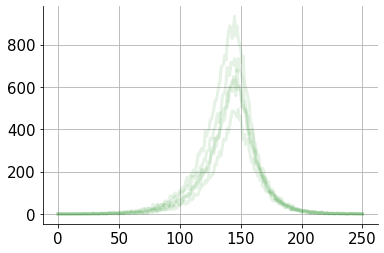

In [7]:
fig,ax=plt.subplots()
for i in range(5):
    out=model.sim(250,checkpoints=chk)
    sumNIS=out.sum(dim="NIS").sum(dim="Nc")
    plt.plot(out["time"],sumNIS["H_in"],alpha=0.10,color='green')

## Visualisation on a map

### Read the arrondissements shape file

In [8]:
# Read shape file
gemeentes = gp.read_file("../../data/raw/geological/BELGIUM__Municipalities.shp")
# select the columns that you with to use for the dissolve and that will be retained
gemeentes_new = gemeentes[['arrond','geometry']]
# dissolve the state boundary by region 
arrondissementen = gemeentes_new.dissolve(by='arrond')

### Perform a single simulation

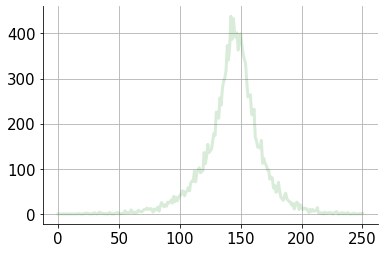

In [9]:
out=model.sim(250,checkpoints=chk)
sumNIS=out.sum(dim="NIS").sum(dim="Nc")
plt.plot(out["time"],sumNIS["H_in"],alpha=0.15,color='green')

In [11]:
output_path = 'charts/maps'

# create the plot
fig, ax = plt.subplots(figsize = (12,12))

start = 40

for day in range(start,len(out['time'].values)):
    # Get data
    data2plot = out.sum(dim="Nc")['H_in'][:,day].values
    print(data2plot)
    arrondissementen['data'] = data2plot
    # Visualize data
    if day == start:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma', vmin=0, vmax=30, legend=True)
    else:
        fig = arrondissementen.plot(column = 'data', ax=ax, cmap='plasma', vmin=0, vmax=30, legend=False)
    # Disable axis
    ax.set_axis_off()
    # This will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    chart = fig.get_figure()
    chart.savefig('maps/'+str(day)+'_B.jpg',dpi=100)
    
    plt.close()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

[2. 2. 1. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 3. 0. 0. 8. 5. 0. 1. 0. 0. 3. 1. 2. 5. 5. 4. 1. 0.]
[4. 1. 0. 2. 1. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 3. 4. 1. 1. 0. 0. 0. 6. 0. 1. 4. 5. 1. 1. 0.]
[4. 0. 1. 0. 1. 0. 0. 0. 0. 1. 2. 0. 0. 0. 1. 1. 1. 0. 3. 0. 0. 0. 3. 1.
 0. 0. 2. 0. 4. 2. 1. 0. 1. 0. 1. 4. 2. 1. 3. 3. 2. 3. 1.]
[1. 2. 0. 1. 0. 2. 5. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 4. 0. 1.
 1. 0. 1. 0. 1. 3. 2. 0. 4. 2. 0. 4. 0. 0. 2. 6. 2. 2. 2.]
[2. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 3. 0. 0. 0. 5. 2.
 0. 1. 1. 1. 1. 7. 2. 1. 1. 1. 0. 2. 5. 2. 3. 0. 6. 6. 0.]
[1. 0. 2. 2. 1. 1. 1. 2. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 2. 0. 3. 0.
 0. 0. 0. 2. 1. 6. 4. 0. 1. 0. 0. 2. 1. 1. 4. 3. 0. 6. 1.]
[0. 0. 2. 4. 3. 1. 4. 1. 0. 1. 0. 0. 1. 0. 0. 2. 1. 2. 1. 1. 1. 2. 5. 1.
 0. 1. 1. 0. 1. 9. 3. 1. 4. 0. 1. 0. 2. 1. 3. 0. 3. 6. 0.]
[2. 3. 0. 2. 1. 0. 0. 2. 0. 1. 1. 2. 0. 1. 0. 1. 1. 0. 3. 1. 0. 0. 3. 4.
 0.

[32. 10. 11. 34.  9. 22. 12.  9.  0.  3.  3.  8.  2.  1.  1. 10.  3.  3.
 21.  2.  4.  4. 21.  7.  5.  9.  1.  8.  0. 29. 17.  7.  9.  4.  9.  0.
  2.  3.  2.  0.  3. 13.  2.]
[37.  3.  9. 24. 18. 15. 15. 11.  0.  5.  9.  3.  1.  5.  2.  8.  3.  4.
 13.  1.  4.  4. 16.  6.  3.  8. 11.  9.  3. 33. 17.  2.  5.  1.  4.  0.
  0.  1.  4.  0.  6. 18.  2.]
[29. 14.  8. 39. 17.  7.  7.  6.  0.  3. 13.  4.  2.  0.  4. 10.  5.  0.
 15.  6.  4.  2. 18.  7.  2.  2.  9.  5.  5. 23. 12.  5. 11.  8.  8.  0.
  1.  1.  2.  1.  4. 10.  5.]
[29.  8.  6. 23. 17.  7. 19.  8.  2.  2.  4.  5.  2.  3.  3.  4.  1.  2.
 15.  6. 12.  1. 16. 11.  3.  4.  6.  5.  3. 26.  4.  3.  3.  2.  6.  0.
  1.  2.  1.  3.  1. 14.  0.]
[23.  7.  9. 28. 14. 13. 10.  7.  1.  3.  3.  7.  3.  1.  2.  6.  4.  3.
  7.  2.  2.  0.  8. 10.  2.  7.  4.  7.  5. 25.  4.  2.  8.  5.  4.  1.
  0.  1.  1.  0.  4.  5.  1.]
[32. 12.  5. 23. 13.  9.  8. 11.  0.  2.  4.  3.  2.  0.  2.  5.  1.  5.
 10.  4.  1.  4. 20.  7.  2.  3.  3.  3.  3. 25

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 2. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 5. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

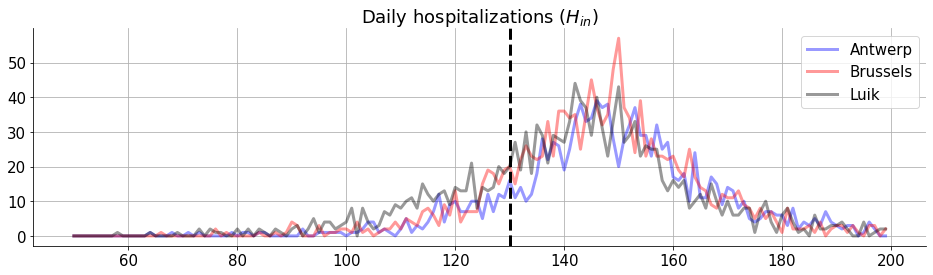

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(16, 4)
ax.plot(out['time'][50:200],out.isel(NIS=0).sum(dim='Nc')['H_in'][50:200],color='blue',alpha=0.40)
ax.plot(out['time'][50:200],out.isel(NIS=3).sum(dim='Nc')['H_in'][50:200],color='red',alpha=0.40)
ax.plot(out['time'][50:200],out.isel(NIS=-14).sum(dim='Nc')['H_in'][50:200],color='black',alpha=0.40)
ax.legend(['Antwerp','Brussels','Luik'])
ax.axvline(130,color='black',linestyle='dashed')
ax.set_title('Daily hospitalizations $(H_{in})$')
fig.savefig('daily_hosp.jpg',dpi=300)